In [987]:
# Demange Aymeric 02/10/2020
# Projet sur un dataset d'anime


import seaborn as sns
import pandas as pd
import warnings

from sklearn.neighbors import KNeighborsClassifier as KNN #KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import numpy as np



warnings.filterwarnings("ignore")

sns.set

# charger le dataset
dataAnime = pd.read_csv(r"/content/dataanime.csv")
df_dataAnime = dataAnime.copy()

In [988]:
# Cette fonction permet de convertir les tirets en "Unknown" en leur passant en argument la colonne en question

def dashToUnknown(value) :
    if (value == '-' ) :
      return 'Unknown'
    else : 
      return value

def fillEndingDate(row) :
  if ( (row.Type == 3 or row.Type == 0) and row.EndingDate == '-') :
    row.EndingDate = row.StartingDate
  return row

def getBroadcastDay(value) :
    splitted = value.split()
    return splitted[0]

def getBroadcastTime(value) :
    splitted = value.split()
    if (len(splitted)== 4) :
      return splitted[2]
    else :
      return 'Unknown'

def getSplittedByComa(value) :
    splitted = value.split(",")
    return splitted

def getSplittedByBlankSpace(value) :
    splitted = value.split()
    return splitted

def copyDf(df,dfToCopy) :
  for col in dfToCopy.columns:
      df[col] = dfToCopy[col]

def getTimePerTitle(value) :
  splitted = value.replace("-","0")
  splitted = splitted.replace("per ep.","").split()
  if (len(splitted) == 4) :
    return (int(splitted[0])*60 + int(splitted[2]))
  elif (len(splitted) == 2) :
    return (int(splitted[0]) * int(df_dataAnime.Episodes.iloc[0]))
  else :
    return (splitted[0])

# Petite fonction permettant de calculer l'accuracy et ensuite de le mettre en %
def accuracy(preds, Y):
  return ((preds == Y).sum() / len(Y)* 100)



---


# **Voici notre dataframe d'origine**

---



In [989]:
df_dataAnime

,Title,Type,Episodes,Status,Start airing,End airing,Starting season,Broadcast time,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Score,Scored by,Members,Favorites,Description
0,Fullmetal Alchemist: Brotherhood,TV,64,Finished Airing,2009-4-5,2010-7-4,Spring,Sundays at 17:00 (JST),"Aniplex,Square Enix,Mainichi Broadcasting Syst...","Funimation,Aniplex of America",Bones,Manga,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,R,9.25,719706,1176368,105387,"""In order for something to be obtained, someth..."
1,Kimi no Na wa.,Movie,1,Finished Airing,2016-8-26,-,-,-,"Kadokawa Shoten,Toho,Sound Team Don Juan,Lawso...","Funimation,NYAV Post",CoMix Wave Films,Original,"Supernatural,Drama,Romance,School",1 hr. 46 min.,PG-13,9.19,454969,705186,33936,"Mitsuha Miyamizu, a high school girl, yearns t..."
2,Gintama°,TV,51,Finished Airing,2015-4-8,2016-3-30,Spring,Wednesdays at 18:00 (JST),"TV Tokyo,Aniplex,Dentsu","Funimation,Crunchyroll",Bandai Namco Pictures,Manga,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,R,9.16,70279,194359,5597,"Gintoki, Shinpachi, and Kagura return as the f..."
3,Steins;Gate 0,TV,23,Currently Airing,2018-4-12,-,Spring,Thursdays at 01:35 (JST),Nitroplus,Funimation,White Fox,Visual novel,"Sci-Fi,Thriller",23 min. per ep.,PG-13,9.16,12609,186331,1117,The dark untold story of Steins;Gate that lead...
4,Steins;Gate,TV,24,Finished Airing,2011-4-6,2011-9-14,Spring,Wednesdays at 02:05 (JST),"Frontier Works,Media Factory,Movic,AT-X,Kadoka...",Funimation,White Fox,Visual novel,"Sci-Fi,Thriller",24 min. per ep.,PG-13,9.14,552791,990419,90365,The self-proclaimed mad scientist Rintarou Oka...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,TV,12,Finished Airing,2010-7-2,2010-9-17,Summer,-,"Aniplex,Square Enix,Mainichi Broadcasting System",Funimation,A-1 Pictures,Manga,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,R,7.48,171506,296985,3576,The stage of Kuroshitsuji II opens on the life...
1559,Minami-ke Natsuyasumi,OVA,1,Finished Airing,2013-8-6,-,-,-,Starchild Records,-,feel.,Manga,"Comedy,Slice of Life",28 min.,PG-13,7.48,6062,12111,4,Second Minami-ke OVA bundled with the 11th vol...
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,Movie,1,Finished Airing,2009-8-1,-,-,-,Toho,Viz Media,Studio Pierrot,Manga,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,PG-13,7.48,61505,104288,129,Ninjas with bloodline limits begin disappearin...
1561,Persona 4 the Animation: The Factor of Hope,Movie,1,Finished Airing,2012-6-9,-,-,-,Index,-,AIC A.S.T.A.,-,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,PG-13,7.48,3054,12868,12,Recap of the entire 25-episode television anim...


# ***Phase de Data Cleaning***


**On drop les NaN afin  clean notre dataframe**



In [990]:
# Je décide de drop tous les na dans les datasets afin de supprimer d'éventuels exemples érronés 
df_dataAnime = df_dataAnime.dropna()

**On clean le nom de nos colonnes car il y a des espaces dedans**

In [991]:
df_dataAnime.rename(columns={'Start airing': 'StartingDate', 'End airing': 'EndingDate', 'Starting season':'StartingSeason', 'Broadcast time':'BroadcastTime','Scored by':'ScoredBy'}, inplace=True)
df_dataAnime

,Title,Type,Episodes,Status,StartingDate,EndingDate,StartingSeason,BroadcastTime,Producers,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,Description
0,Fullmetal Alchemist: Brotherhood,TV,64,Finished Airing,2009-4-5,2010-7-4,Spring,Sundays at 17:00 (JST),"Aniplex,Square Enix,Mainichi Broadcasting Syst...","Funimation,Aniplex of America",Bones,Manga,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,R,9.25,719706,1176368,105387,"""In order for something to be obtained, someth..."
1,Kimi no Na wa.,Movie,1,Finished Airing,2016-8-26,-,-,-,"Kadokawa Shoten,Toho,Sound Team Don Juan,Lawso...","Funimation,NYAV Post",CoMix Wave Films,Original,"Supernatural,Drama,Romance,School",1 hr. 46 min.,PG-13,9.19,454969,705186,33936,"Mitsuha Miyamizu, a high school girl, yearns t..."
2,Gintama°,TV,51,Finished Airing,2015-4-8,2016-3-30,Spring,Wednesdays at 18:00 (JST),"TV Tokyo,Aniplex,Dentsu","Funimation,Crunchyroll",Bandai Namco Pictures,Manga,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,R,9.16,70279,194359,5597,"Gintoki, Shinpachi, and Kagura return as the f..."
3,Steins;Gate 0,TV,23,Currently Airing,2018-4-12,-,Spring,Thursdays at 01:35 (JST),Nitroplus,Funimation,White Fox,Visual novel,"Sci-Fi,Thriller",23 min. per ep.,PG-13,9.16,12609,186331,1117,The dark untold story of Steins;Gate that lead...
4,Steins;Gate,TV,24,Finished Airing,2011-4-6,2011-9-14,Spring,Wednesdays at 02:05 (JST),"Frontier Works,Media Factory,Movic,AT-X,Kadoka...",Funimation,White Fox,Visual novel,"Sci-Fi,Thriller",24 min. per ep.,PG-13,9.14,552791,990419,90365,The self-proclaimed mad scientist Rintarou Oka...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,TV,12,Finished Airing,2010-7-2,2010-9-17,Summer,-,"Aniplex,Square Enix,Mainichi Broadcasting System",Funimation,A-1 Pictures,Manga,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,R,7.48,171506,296985,3576,The stage of Kuroshitsuji II opens on the life...
1559,Minami-ke Natsuyasumi,OVA,1,Finished Airing,2013-8-6,-,-,-,Starchild Records,-,feel.,Manga,"Comedy,Slice of Life",28 min.,PG-13,7.48,6062,12111,4,Second Minami-ke OVA bundled with the 11th vol...
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,Movie,1,Finished Airing,2009-8-1,-,-,-,Toho,Viz Media,Studio Pierrot,Manga,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,PG-13,7.48,61505,104288,129,Ninjas with bloodline limits begin disappearin...
1561,Persona 4 the Animation: The Factor of Hope,Movie,1,Finished Airing,2012-6-9,-,-,-,Index,-,AIC A.S.T.A.,-,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,PG-13,7.48,3054,12868,12,Recap of the entire 25-episode television anim...


**Ici on vas transformer nos lignes / Colonnes qui peuvent être directement faites**

In [992]:
# Je vais ensuite transformer mes colonnes qualitative en donnée quantitative via la méthode : "labelencoder"
# Cette méthode permet de trouver toutes les différentes valeur présentes dans une colonne et d'associer une valeur numérique à la place. 
# Si deux valeurs sont identiques elles prennent le même nombre

df_dataAnime['Rating'] = labelencoder.fit_transform(df_dataAnime['Rating'])


# La colonne "Type" possède des valeurs qui peuvent être transformé en booléen. J'utilise la méthode cat.codes

df_dataAnime.Type = df_dataAnime['Type'].astype('category').cat.codes
df_dataAnime.Status = df_dataAnime['Status'].astype('category').cat.codes
df_dataAnime.Sources = df_dataAnime['Sources'].astype('category').cat.codes


df_dataAnime = df_dataAnime.drop(['Description', 'Producers'], axis= 1)


# Ces lignes ne marche pas pour le moment car il faut split leurs valeurs
#df_dataAnime.Genres = df_dataAnime['Genres'].astype('category').cat.codes




df_dataAnime

,Title,Type,Episodes,Status,StartingDate,EndingDate,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites
0,Fullmetal Alchemist: Brotherhood,5,64,1,2009-4-5,2010-7-4,Spring,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387
1,Kimi no Na wa.,0,1,1,2016-8-26,-,-,-,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936
2,Gintama°,5,51,1,2015-4-8,2016-3-30,Spring,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597
3,Steins;Gate 0,5,23,0,2018-4-12,-,Spring,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117
4,Steins;Gate,5,24,1,2011-4-6,2011-9-14,Spring,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2010-7-2,2010-9-17,Summer,-,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576
1559,Minami-ke Natsuyasumi,3,1,1,2013-8-6,-,-,-,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,2009-8-1,-,-,-,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,2012-6-9,-,-,-,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12


**Afin de pouvoir utiliser la date je souhaite connaitre son type**

In [993]:
df_dataAnime.StartingSeason.describe()

count     1563
unique       5
top          -
freq       742
Name: StartingSeason, dtype: object

In [994]:
df_dataAnime.StartingSeason = df_dataAnime.StartingSeason.apply(dashToUnknown)
df_dataAnime

,Title,Type,Episodes,Status,StartingDate,EndingDate,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites
0,Fullmetal Alchemist: Brotherhood,5,64,1,2009-4-5,2010-7-4,Spring,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387
1,Kimi no Na wa.,0,1,1,2016-8-26,-,Unknown,-,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936
2,Gintama°,5,51,1,2015-4-8,2016-3-30,Spring,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597
3,Steins;Gate 0,5,23,0,2018-4-12,-,Spring,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117
4,Steins;Gate,5,24,1,2011-4-6,2011-9-14,Spring,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2010-7-2,2010-9-17,Summer,-,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576
1559,Minami-ke Natsuyasumi,3,1,1,2013-8-6,-,Unknown,-,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,2009-8-1,-,Unknown,-,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,2012-6-9,-,Unknown,-,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12


In [995]:
df_dataAnime.StartingSeason = df_dataAnime['StartingSeason'].astype('category').cat.codes
df_dataAnime

,Title,Type,Episodes,Status,StartingDate,EndingDate,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites
0,Fullmetal Alchemist: Brotherhood,5,64,1,2009-4-5,2010-7-4,1,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387
1,Kimi no Na wa.,0,1,1,2016-8-26,-,3,-,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936
2,Gintama°,5,51,1,2015-4-8,2016-3-30,1,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597
3,Steins;Gate 0,5,23,0,2018-4-12,-,1,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117
4,Steins;Gate,5,24,1,2011-4-6,2011-9-14,1,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2010-7-2,2010-9-17,2,-,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576
1559,Minami-ke Natsuyasumi,3,1,1,2013-8-6,-,3,-,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,2009-8-1,-,3,-,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,2012-6-9,-,3,-,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12


In [996]:
# Pour gérer mes dates je veux savoir leur format de base, c'est donc des objets, il faut les passer en dateTime pour utiliser pandas avec
df_dataAnime.StartingDate.head(5)

0     2009-4-5
1    2016-8-26
2     2015-4-8
3    2018-4-12
4     2011-4-6
Name: StartingDate, dtype: object

In [997]:
df_dataAnime = df_dataAnime.apply(fillEndingDate, axis=1)
df_dataAnime

,Title,Type,Episodes,Status,StartingDate,EndingDate,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites
0,Fullmetal Alchemist: Brotherhood,5,64,1,2009-4-5,2010-7-4,1,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387
1,Kimi no Na wa.,0,1,1,2016-8-26,2016-8-26,3,-,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936
2,Gintama°,5,51,1,2015-4-8,2016-3-30,1,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597
3,Steins;Gate 0,5,23,0,2018-4-12,-,1,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117
4,Steins;Gate,5,24,1,2011-4-6,2011-9-14,1,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2010-7-2,2010-9-17,2,-,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576
1559,Minami-ke Natsuyasumi,3,1,1,2013-8-6,2013-8-6,3,-,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,2009-8-1,2009-8-1,3,-,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,2012-6-9,2012-6-9,3,-,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12


In [998]:
# Je transforme mes dates via la méthode "to_datetime". Je gère les erreurs via l'argument 'coerce' qui lorsqu'il voit quelque chose ne possédant pas le format choisi assigne la valeur NaT

df_dataAnime.StartingDate = pd.to_datetime(df_dataAnime.StartingDate, 
 format = '%Y-%m-%dT',
 errors = 'coerce')

df_dataAnime.EndingDate = pd.to_datetime(df_dataAnime.EndingDate, 
 format = '%Y-%m-%dT',
 errors = 'coerce')

df_dataAnime

,Title,Type,Episodes,Status,StartingDate,EndingDate,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites
0,Fullmetal Alchemist: Brotherhood,5,64,1,2009-04-05,2010-07-04,1,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387
1,Kimi no Na wa.,0,1,1,2016-08-26,2016-08-26,3,-,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936
2,Gintama°,5,51,1,2015-04-08,2016-03-30,1,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597
3,Steins;Gate 0,5,23,0,2018-04-12,NaT,1,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117
4,Steins;Gate,5,24,1,2011-04-06,2011-09-14,1,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2010-07-02,2010-09-17,2,-,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576
1559,Minami-ke Natsuyasumi,3,1,1,2013-08-06,2013-08-06,3,-,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,2009-08-01,2009-08-01,3,-,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,2012-06-09,2012-06-09,3,-,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12


In [999]:
# Maintenant que mes dates sont bien au format DateTime je peut via pandas séparer les dates.
# Je crée des colonnes pour chaque partie de mes dates

df_dataAnime['StartingDate_year'] = df_dataAnime.StartingDate.dt.year
df_dataAnime['StartingDate_month'] = df_dataAnime.StartingDate.dt.month
df_dataAnime['StartingDate_day'] = df_dataAnime.StartingDate.dt.day

df_dataAnime['EndingDate_year'] = df_dataAnime.EndingDate.dt.year
df_dataAnime['EndingDate_month'] = df_dataAnime.EndingDate.dt.month
df_dataAnime['EndingDate_day'] = df_dataAnime.EndingDate.dt.day

# Je drop StartingDate et EndingDate car j'ai fractionné mes dates, je n'en ai plus besoin dans ce format

df_dataAnime = df_dataAnime.drop(['StartingDate','EndingDate'], axis= 1)

df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0
1,Kimi no Na wa.,0,1,1,3,-,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0
2,Gintama°,5,51,1,1,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0
3,Steins;Gate 0,5,23,0,1,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN
4,Steins;Gate,5,24,1,1,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,-,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0
1559,Minami-ke Natsuyasumi,3,1,1,3,-,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,-,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,-,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0


In [1000]:
df_dataAnime.BroadcastTime = df_dataAnime.BroadcastTime.apply(dashToUnknown)
df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,Sundays at 17:00 (JST),"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0
1,Kimi no Na wa.,0,1,1,3,Unknown,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0
2,Gintama°,5,51,1,1,Wednesdays at 18:00 (JST),"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0
3,Steins;Gate 0,5,23,0,1,Thursdays at 01:35 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN
4,Steins;Gate,5,24,1,1,Wednesdays at 02:05 (JST),Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,Unknown,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0
1559,Minami-ke Natsuyasumi,3,1,1,3,Unknown,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,Unknown,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,Unknown,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0


In [1001]:
df_dataAnime['BroadcastDay'] = df_dataAnime.BroadcastTime.apply(getBroadcastDay)
df_dataAnime['BroadcastTime'] = df_dataAnime.BroadcastTime.apply(getBroadcastTime)

df_dataAnime['BroadcastDay'] = labelencoder.fit_transform(df_dataAnime['BroadcastDay'])
df_dataAnime['BroadcastTime'] = labelencoder.fit_transform(df_dataAnime['BroadcastTime'])

df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,59,"Funimation,Aniplex of America",Bones,6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4
1,Kimi no Na wa.,0,1,1,3,81,"Funimation,NYAV Post",CoMix Wave Films,9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7
2,Gintama°,5,51,1,1,63,"Funimation,Crunchyroll",Bandai Namco Pictures,6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8
3,Steins;Gate 0,5,23,0,1,19,Funimation,White Fox,12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN,5
4,Steins;Gate,5,24,1,1,26,Funimation,White Fox,12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,81,Funimation,A-1 Pictures,6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7
1559,Minami-ke Natsuyasumi,3,1,1,3,81,-,feel.,6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,81,Viz Media,Studio Pierrot,6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,81,-,AIC A.S.T.A.,0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7


In [1002]:
# On appelle la fonction getSplittedByBlankSpace afin de pouvoir creer une liste en fonction d'une séparation par un espace.
# Une fois une liste crée on vas encoder chaque ligne et chaque objet via labelEncoder

df_dataAnime.Studios = df_dataAnime.Studios.apply(getSplittedByBlankSpace)

df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,59,"Funimation,Aniplex of America",[Bones],6,"Action,Military,Adventure,Comedy,Drama,Magic,F...",24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4
1,Kimi no Na wa.,0,1,1,3,81,"Funimation,NYAV Post","[CoMix, Wave, Films]",9,"Supernatural,Drama,Romance,School",1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7
2,Gintama°,5,51,1,1,63,"Funimation,Crunchyroll","[Bandai, Namco, Pictures]",6,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8
3,Steins;Gate 0,5,23,0,1,19,Funimation,"[White, Fox]",12,"Sci-Fi,Thriller",23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN,5
4,Steins;Gate,5,24,1,1,26,Funimation,"[White, Fox]",12,"Sci-Fi,Thriller",24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,81,Funimation,"[A-1, Pictures]",6,"Action,Comedy,Demons,Supernatural,Fantasy,Shounen",24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7
1559,Minami-ke Natsuyasumi,3,1,1,3,81,-,[feel.],6,"Comedy,Slice of Life",28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,81,Viz Media,"[Studio, Pierrot]",6,"Action,Comedy,Martial Arts,Shounen,Super Power",1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,81,-,"[AIC, A.S.T.A.]",0,"Adventure,Mystery,Super Power,Supernatural,School",1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7


In [1003]:
# On appelle la fonction getSplittedByComa afin de pouvoir creer une liste en fonction d'une séparation par une virgule.
# Une fois une liste crée on vas encoder chaque ligne et chaque objet via labelEncoder

#df_dataAnime.Producers = df_dataAnime.Producers.apply(getSplittedByComa)
df_dataAnime.Licensors = df_dataAnime.Licensors.apply(getSplittedByComa)
df_dataAnime.Genres = df_dataAnime.Genres.apply(getSplittedByComa)

df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Licensors,Studios,Sources,Genres,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,59,"[Funimation, Aniplex of America]",[Bones],6,"[Action, Military, Adventure, Comedy, Drama, M...",24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4
1,Kimi no Na wa.,0,1,1,3,81,"[Funimation, NYAV Post]","[CoMix, Wave, Films]",9,"[Supernatural, Drama, Romance, School]",1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7
2,Gintama°,5,51,1,1,63,"[Funimation, Crunchyroll]","[Bandai, Namco, Pictures]",6,"[Action, Comedy, Historical, Parody, Samurai, ...",24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8
3,Steins;Gate 0,5,23,0,1,19,[Funimation],"[White, Fox]",12,"[Sci-Fi, Thriller]",23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN,5
4,Steins;Gate,5,24,1,1,26,[Funimation],"[White, Fox]",12,"[Sci-Fi, Thriller]",24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,81,[Funimation],"[A-1, Pictures]",6,"[Action, Comedy, Demons, Supernatural, Fantasy...",24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7
1559,Minami-ke Natsuyasumi,3,1,1,3,81,[-],[feel.],6,"[Comedy, Slice of Life]",28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,81,[Viz Media],"[Studio, Pierrot]",6,"[Action, Comedy, Martial Arts, Shounen, Super ...",1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,81,[-],"[AIC, A.S.T.A.]",0,"[Adventure, Mystery, Super Power, Supernatural...",1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7


In [1004]:

newdf_dataAnime = df_dataAnime.Genres.apply(frozenset).to_frame(name='Genres')

for Genres in frozenset.union(*newdf_dataAnime.Genres):
  newdf_dataAnime[Genres] = newdf_dataAnime.apply(lambda x: int(Genres in x.Genres), axis=1)

copyDf(df_dataAnime, newdf_dataAnime)


In [1005]:
newdf_dataAnime = df_dataAnime.Licensors.apply(frozenset).to_frame(name='Licensors')

for Licensors in frozenset.union(*newdf_dataAnime.Licensors):
  newdf_dataAnime[Licensors] = newdf_dataAnime.apply(lambda x: int(Licensors in x.Licensors), axis=1)

copyDf(df_dataAnime, newdf_dataAnime)


In [1006]:
newdf_dataAnime = df_dataAnime.Studios.apply(frozenset).to_frame(name='Studios')

for Studios in frozenset.union(*newdf_dataAnime.Studios):
  newdf_dataAnime[Studios] = newdf_dataAnime.apply(lambda x: int(Studios in x.Studios), axis=1)

copyDf(df_dataAnime, newdf_dataAnime)


In [1007]:
df_dataAnime = df_dataAnime.drop(['Licensors', 'Genres','Studios'], axis= 1)

df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Sources,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay,Dementia,Space,Slice of Life,Horror,Parody,Military,Shounen,Drama,Martial Arts,Thriller,School,Samurai,Shounen Ai,Adventure,Demons,Game,Sports,Romance,Magic,Seinen,...,Classic,Telescreen,"Artland,Madhouse","Entertainment,Telecom",Investment,Maker,Staff,Fuji,"Deen,Magic",Kyoto,"Gallop,Studio",Entertainment,Shuka,"Satelight,A-1",Square,Gainax,Pastel,SANZIGEN,Deen,Link.,"Spirits,Asread",Citrus,Triangle,"Comet,KeyEast,REALTHING",Khara,Kobo,LIDENFILMS,"Madhouse,Satelight,Graphinica",Arts,SARU,"Satelight,8bit",Oh!,4°C,Hibari,Gonzo,Shaft,Toei,L²Studio,Encourage,CoMix
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,59,6,24 min. per ep.,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Kimi no Na wa.,0,1,1,3,81,9,1 hr. 46 min.,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Gintama°,5,51,1,1,63,6,24 min. per ep.,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Steins;Gate 0,5,23,0,1,19,12,23 min. per ep.,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Steins;Gate,5,24,1,1,26,12,24 min. per ep.,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,81,6,24 min. per ep.,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1559,Minami-ke Natsuyasumi,3,1,1,3,81,6,28 min.,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,81,6,1 hr. 35 min.,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,81,0,1 hr. 30 min.,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1008]:
df_dataAnime.Duration = df_dataAnime.Duration.apply(getTimePerTitle)
df_dataAnime

,Title,Type,Episodes,Status,StartingSeason,BroadcastTime,Sources,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay,Dementia,Space,Slice of Life,Horror,Parody,Military,Shounen,Drama,Martial Arts,Thriller,School,Samurai,Shounen Ai,Adventure,Demons,Game,Sports,Romance,Magic,Seinen,...,Classic,Telescreen,"Artland,Madhouse","Entertainment,Telecom",Investment,Maker,Staff,Fuji,"Deen,Magic",Kyoto,"Gallop,Studio",Entertainment,Shuka,"Satelight,A-1",Square,Gainax,Pastel,SANZIGEN,Deen,Link.,"Spirits,Asread",Citrus,Triangle,"Comet,KeyEast,REALTHING",Khara,Kobo,LIDENFILMS,"Madhouse,Satelight,Graphinica",Arts,SARU,"Satelight,8bit",Oh!,4°C,Hibari,Gonzo,Shaft,Toei,L²Studio,Encourage,CoMix
0,Fullmetal Alchemist: Brotherhood,5,64,1,1,59,6,1536,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Kimi no Na wa.,0,1,1,3,81,9,106,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Gintama°,5,51,1,1,63,6,1536,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Steins;Gate 0,5,23,0,1,19,12,1472,3,9.16,12609,186331,1117,2018.0,4.0,12.0,NaN,NaN,NaN,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Steins;Gate,5,24,1,1,26,12,1536,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,Kuroshitsuji II,5,12,1,2,81,6,1536,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1559,Minami-ke Natsuyasumi,3,1,1,3,81,6,1792,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1560,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0,1,1,3,81,6,95,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1561,Persona 4 the Animation: The Factor of Hope,0,1,1,3,81,0,90,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1009]:
df_dataAnime = df_dataAnime.dropna()

In [1010]:
df_dataAnime = df_dataAnime.drop(['Title'], axis= 1)

In [1011]:
# On vire tous les tirets restants CAD : 11. En gros tous les titres des séries qui sont toujours en cours
df_dataAnime = df_dataAnime[df_dataAnime.Episodes != '-']
df_dataAnime

,Type,Episodes,Status,StartingSeason,BroadcastTime,Sources,Duration,Rating,Score,ScoredBy,Members,Favorites,StartingDate_year,StartingDate_month,StartingDate_day,EndingDate_year,EndingDate_month,EndingDate_day,BroadcastDay,Dementia,Space,Slice of Life,Horror,Parody,Military,Shounen,Drama,Martial Arts,Thriller,School,Samurai,Shounen Ai,Adventure,Demons,Game,Sports,Romance,Magic,Seinen,Adventure,...,Classic,Telescreen,"Artland,Madhouse","Entertainment,Telecom",Investment,Maker,Staff,Fuji,"Deen,Magic",Kyoto,"Gallop,Studio",Entertainment,Shuka,"Satelight,A-1",Square,Gainax,Pastel,SANZIGEN,Deen,Link.,"Spirits,Asread",Citrus,Triangle,"Comet,KeyEast,REALTHING",Khara,Kobo,LIDENFILMS,"Madhouse,Satelight,Graphinica",Arts,SARU,"Satelight,8bit",Oh!,4°C,Hibari,Gonzo,Shaft,Toei,L²Studio,Encourage,CoMix
0,5,64,1,1,59,6,1536,4,9.25,719706,1176368,105387,2009.0,4.0,5.0,2010.0,7.0,4.0,4,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,3,81,9,106,3,9.19,454969,705186,33936,2016.0,8.0,26.0,2016.0,8.0,26.0,7,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,5,51,1,1,63,6,1536,4,9.16,70279,194359,5597,2015.0,4.0,8.0,2016.0,3.0,30.0,8,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,24,1,1,26,12,1536,3,9.14,552791,990419,90365,2011.0,4.0,6.0,2011.0,9.0,14.0,8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,3,110,1,3,81,8,1664,4,9.11,28452,121772,8370,1988.0,1.0,8.0,1997.0,3.0,17.0,7,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,5,12,1,2,81,6,1536,4,7.48,171506,296985,3576,2010.0,7.0,2.0,2010.0,9.0,17.0,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1559,3,1,1,3,81,6,1792,3,7.48,6062,12111,4,2013.0,8.0,6.0,2013.0,8.0,6.0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1560,0,1,1,3,81,6,95,3,7.48,61505,104288,129,2009.0,8.0,1.0,2009.0,8.0,1.0,7,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1561,0,1,1,3,81,0,90,3,7.48,3054,12868,12,2012.0,6.0,9.0,2012.0,6.0,9.0,7,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1012]:
# df_dataAnime.loc[df_dataAnime['EndingDate_year'] =='-']

In [1034]:
df_dataAnime.Score = df_dataAnime.Score * 100
df_dataAnime.StartingDate_year = df_dataAnime.StartingDate_year.apply(int)
df_dataAnime.StartingDate_month = df_dataAnime.StartingDate_month.apply(int)
df_dataAnime.StartingDate_day = df_dataAnime.StartingDate_day.apply(int)

df_dataAnime.EndingDate_year = df_dataAnime.EndingDate_year.apply(int)
df_dataAnime.EndingDate_month = df_dataAnime.EndingDate_month.apply(int)
df_dataAnime.EndingDate_day = df_dataAnime.EndingDate_day.apply(int)

df_dataAnime

df_dataAnime = df_dataAnime.astype(int)

In [1035]:
# J'isole ma target
Y = df_dataAnime['Score']

# J'isole mes features en supprimant ma target et l'adresse IP qui n'a plus d'interet ici 
X = df_dataAnime.drop(['Score'], axis = 1)

In [1037]:
# On vas split notre environnement de travail en 2 grandes parties : L'environnement de prod (test) et d'entrainement (train)
# On vérifie la shape de nos variables afin de s'assurer de possèder le bon nombre de colonnes et de lignes
splits = train_test_split(X,Y,
                          random_state=0)

for each in splits:
  print(each.shape)
X_train, X_test, Y_train, Y_test = splits
scaler = StandardScaler()

(1043, 347)
(348, 347)
(1043,)
(348,)


# ***RANDOM FOREST CLASSIFIER***

In [1040]:
# On applique l'algorithme RandomForest
rf = RF()
rf.fit(X_train,Y_train)
prediction = rf.predict(X_test)
proba = rf.predict_proba(X_test)
print(prediction)
print(proba)

[771 756 789 814 834 769 800 757 774 762 768 750 759 766 792 768 792 749
 754 814 760 801 784 752 753 786 755 855 757 778 786 836 819 776 800 751
 844 760 791 779 819 821 786 763 772 787 776 790 749 818 752 832 846 775
 792 749 766 786 807 864 759 752 827 762 775 760 836 838 757 750 772 796
 819 775 851 789 916 751 786 762 849 791 821 861 756 791 795 775 842 811
 782 872 779 757 777 785 766 775 749 844 848 756 799 774 766 790 762 750
 760 755 821 799 855 821 856 770 756 792 766 801 755 777 766 754 789 760
 771 801 751 762 819 786 749 810 770 771 844 752 766 821 771 824 751 750
 819 788 777 765 802 752 785 771 802 832 756 769 758 844 771 773 773 771
 811 778 852 836 824 832 761 763 798 806 781 815 775 811 756 844 786 844
 755 765 783 781 784 786 755 779 777 789 782 749 782 835 789 809 779 857
 789 800 779 760 773 806 789 832 864 776 790 766 749 838 827 750 789 775
 777 785 754 853 799 752 768 785 775 756 799 769 763 817 777 751 760 748
 764 756 750 749 790 760 811 866 807 856 783 766 75

In [1041]:
# On observe une accuracy de 94% dans ce test avec comme hyperparamètre random_state=0
accuracy(prediction,Y_test)

1.1494252873563218

# ***KNN***

In [1066]:
#Passage des HYPERPARAMETRES
knn = KNN(n_neighbors=97)
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=97, p=2,
                     weights='uniform')

In [1067]:
predictions = knn.predict(X_test)
accuracy(predictions, Y_test)

1.4367816091954022

In [1068]:
# Ici on vas réentrainer notre model pour faire un test d'importance sur nos features
rf.fit(X_train, Y_train)
importance = rf.feature_importances_
importance

array([1.37936453e-02, 2.97366156e-02, 6.71905359e-04, 2.02127127e-02,
       1.93037303e-02, 2.47942738e-02, 3.50633474e-02, 1.62464719e-02,
       4.65797772e-02, 4.69660366e-02, 4.58087048e-02, 3.85997787e-02,
       3.09741441e-02, 3.94850925e-02, 3.68562618e-02, 3.03148839e-02,
       3.97949832e-02, 1.78938192e-02, 5.37487567e-04, 3.63199165e-03,
       1.00422488e-02, 2.46197982e-03, 3.43695953e-03, 5.73277258e-03,
       1.12973193e-02, 1.42986607e-02, 2.72546019e-03, 2.69335059e-03,
       1.00014716e-02, 2.54988079e-03, 1.65971060e-03, 1.09783587e-02,
       4.17630737e-03, 2.98486025e-03, 6.02564195e-03, 1.06164053e-02,
       3.82656254e-04, 6.75065934e-03, 0.00000000e+00, 5.06092849e-03,
       1.44630676e-03, 5.85315175e-03, 1.02007600e-02, 2.81070451e-03,
       2.38379400e-03, 1.24288245e-02, 6.54984751e-03, 1.37767520e-03,
       8.85943328e-03, 4.79230209e-03, 1.58767535e-03, 1.20336601e-03,
       7.36239936e-03, 6.76745802e-03, 1.05977387e-02, 1.36912676e-02,
      

Somme des pouvoirs predictif : 1.0000000000000002


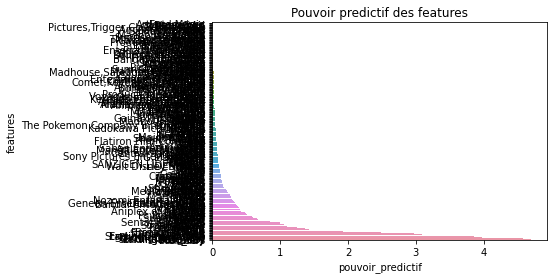

In [1069]:
# Une fois l'importance réalisé on vas la plot afin mieux observer à quel point une feature peut faire varier notre accuracy
# Je crée un nouveau dataframe pour pouvoir stocker seulement les colonnes qui m'intéresse

d = pd.DataFrame()
d['features'] = X_train.columns
d['pouvoir_predictif'] = importance
print('Somme des pouvoirs predictif : {}'.format(d['pouvoir_predictif'].sum()))
d['pouvoir_predictif'] = d['pouvoir_predictif'].apply(lambda v : v*100)
d = d.sort_values(by='pouvoir_predictif', ascending=True)
sns.barplot(d['pouvoir_predictif'], d['features']).set_title('Pouvoir predictif des features');

In [1075]:
d

,features,pouvoir_predictif
149,Enterprises,0.000000
205,"Artland,Magic",0.000000
289,"Deen,DAX",0.000000
236,Yaoyorozu,0.000000
286,"Actas,Studio",0.000000
...,...,...
13,StartingDate_day,3.948509
16,EndingDate_day,3.979498
10,Favorites,4.580870
8,ScoredBy,4.657978


In [1076]:
# Ici on fait une matrice de confusion nous permettant d'observer le nombre de faux positif ou faux négatif.
cm = confusion_matrix(Y_test,prediction)
cm

array([[0, 2, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

NameError: ignored

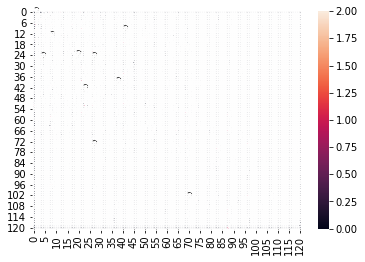

In [1092]:
df_cm = pd.DataFrame(cm)
sns.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
# J'affiche le nombre de fraude en fonction des 10premiers pays
# Pour ça je récupère les colonnes class et ip country et en fait un nouveau dataframe
# Je ne souhaite garder que les cas ou la fraude à été prédit.

#Je groupby pour sur ip_country et additionne la colonne class en fonction des pays

attack_df = fraud_df[fraud_df['class'] == 1]
attack_df = attack_df[['class','IP_country']]
attack_df = attack_df[attack_df.IP_country != 'Unknown']

attack_df

total_attack = attack_df.groupby(by='IP_country', as_index=False).sum().sort_values(by='class', ascending = False)
total_attack.head(15)

sns.barplot(total_attack['class'], total_attack['IP_country'][:10]).set_title('Nombre de fraude en fonction du pays')

In [1077]:
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), proba[:, i].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ValueError: ignored

In [1078]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

KeyError: ignored

In [ ]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()